In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import datetime
import os
import copy
import yaml
import pickle
from PIL import Image

from util.dataload import DataIOStream, CustomDataset
from util.create_data import DataCreateStream
# from model.model import CreateGastricModel

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
yaml_path = os.path.join("..", "config", "train.yaml")
# load config.yaml
with open(yaml_path) as f:
    conf = yaml.safe_load(f)
print('=='*50)
for item in conf:
    print(f'{item}: {conf[item]}')
print('=='*50)
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]=str(conf['gpu'])
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
start_time = time.time()
d = datetime.datetime.now()
now_time = f"{d.year}/{d.month}/{d.day} {d.hour}:{d.minute}:{d.second}"
print(f"Now time: {now_time}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class_box: {'ES': ['ES', 'NO-ES', 'GE-ES'], 'GE': ['GE', 'ES-GE', 'CR-GE', 'NO-GE']}
gpu: 0
model_name: inception_v3
model_weight: IMAGENET1K_V1
batch: 32
optimizer: SGD
epoch: 100
initial_learning_rate: 0.001
learning_rate_gamma: 0.2
Now time: 2023/12/26 16:32:43
cuda:0


In [3]:
def load_imgShape(model_name):
    dict_modelIMGShape = {"AlexNet":224, "ConvNeXt":224, "DenseNet":224, "EfficientNet":224, "EfficientNetV2":224,
                          "GoogLeNet":224, "InceptionV3":512, "MaxVit":224, "MNASNet":224, "MobileNetV2":224,
                          "MobileNet":224, "RegNet":224, "ResNet":224, "ResNeXt":224, "ShuffleNetV2":224,
                          "SqueezeNet":224, "SwinTransformer":224, "VGG":224, "VisionTransformer":224, "WideResNet":224,
    }
    if model_name not in list(dict_modelIMGShape.keys()):
        imgShape = 512
    else:
        imgShape = dict_modelIMGShape[model_name]
    
    return imgShape

In [4]:
class_keys_box = list(conf["class_box"].keys()) # ex) ["ES", "GE", "xx", "xx"]
class_values_box = list(conf["class_box"].values()) # ex) [["ES", "GE"], ["UB", "MB", "LB"], ["xx", "xx"]]
img_size = load_imgShape(model_name=conf["model_name"])
# npy 디텍토리 내부, 클래스 범주를 기준으로 폴더를 구성한다.
class_fpath = os.path.join("..", "..", "npy", "_".join(class_keys_box))
if not os.path.exists(class_fpath):
    os.mkdir(class_fpath)
# npy/{class_fpath} 디렉토리 내부, 이미지 사이즈를 기준으로 폴더를 구성한다.
size_fpath = os.path.join("..", "..", "npy", "_".join(class_keys_box), str(img_size))
if not os.path.exists(size_fpath):
    os.mkdir(size_fpath)
    data_dir = os.path.join("..", "..", "data", "class_box")
    train_dict, test_dict, val_dict = DataCreateStream().data_split(class_box=class_values_box,
                                                                    data_dir=data_dir,
    )
    with open(file=os.path.join(size_fpath, "train.pickle"), mode='wb') as f:
        pickle.dump(train_dict, f, protocol=4)
    with open(file=os.path.join(size_fpath, "test.pickle"), mode='wb') as f:
        pickle.dump(test_dict, f, protocol=4)
    with open(file=os.path.join(size_fpath, "val.pickle"), mode='wb') as f:
        pickle.dump(val_dict, f, protocol=4)
# load dataset
train_dict, test_dict, val_dict = DataIOStream().dataloader_all(path=size_fpath)
train_set = CustomDataset(x_data_paths=train_dict["input_path"],
                          y_data=train_dict["input_label"],
                          img_size=img_size,
)
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=conf["batch"],
                                           shuffle=True,
                                           num_workers=0,
)
test_set = CustomDataset(x_data_paths=test_dict["input_path"],
                         y_data=test_dict["input_label"],
                         img_size=img_size,
)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=conf["batch"],
                                          shuffle=False,
                                          num_workers=0,
)
val_set = CustomDataset(x_data_paths=val_dict["input_path"],
                        y_data=val_dict["input_label"],
                        img_size=img_size,
)
val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=conf["batch"],
                                         shuffle=True,
                                         num_workers=0,
)
data_loaders = {"train": train_loader,
                "test": test_loader,
                "val": val_loader,
}
dataset_sizes = {"train": len(train_dict["input_path"]),
                 "test": len(test_dict["input_path"]),
                 "val": len(val_dict["input_path"]),
}

Class Object: ['ES', 'NO-ES', 'GE-ES']
Count: 4702
Class Object: ['GE', 'ES-GE', 'CR-GE', 'NO-GE']
Count: 2208


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


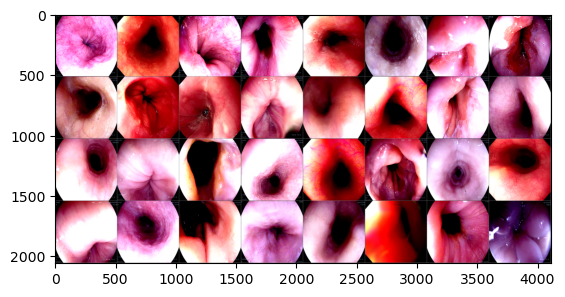

['GE', 'ES', 'GE', 'GE', 'ES', 'ES', 'ES', 'GE', 'ES', 'GE', 'ES', 'GE', 'ES', 'ES', 'GE', 'ES', 'ES', 'GE', 'GE', 'ES', 'ES', 'GE', 'ES', 'ES', 'GE', 'ES', 'GE', 'ES', 'ES', 'GE', 'GE', 'ES']


In [5]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
y_ts = []
for label in labels:
    y_ts.append(class_keys_box[np.argmax(label.numpy(), axis=0)])
print(y_ts)

In [6]:
def train_model(model, 
                criterion, 
                optimizer, 
                scheduler, 
                num_epochs=conf["epoch"]
):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-'*10)
        # 각 에폭 (epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()    # 모델을 학습 모드로 설정합니다.
            else:
                model.eval()     # 모델을 평가 모드로 설정합니다.
            running_loss = 0.0
            running_corrects = 0
            # 데이터를 반복합니다.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # 매개변수 경사도를 0으로 설정합니다.
                optimizer.zero_grad()
                # 순전파
                # 학습시에만 연산 기록을 추적합니다.
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    try:
                        _, preds = torch.max(outputs.logits.to(torch.float64), -1)
                        loss = criterion(outputs.logits.to(torch.float64), labels)
                    except:
                        _, preds = torch.max(outputs.to(torch.float64), -1)
                        loss = criterion(outputs.to(torch.float64), labels)
                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # 통계
                _, trues = torch.max(labels.data, -1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == trues)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    
    return model

In [7]:
def visualize_model(model, 
                    num_images=6
):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, -1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_keys_box[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# 수정 필요
# https://pytorch.org/vision/0.14/models.html#classification
weights = models.Inception_V3_Weights.IMAGENET1K_V1
model_ft = models.inception_v3(weights=weights)
num_ftrs = model_ft.fc.in_features
# ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, len(class_keys_box))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# 모든 매개변수들이 최적화되었는지 관찰
if conf["optimizer"] == "SGD":
    optimizer_ft = optim.SGD(model_ft.parameters(), 
                             lr=conf["initial_learning_rate"], 
                             momentum=0.9
    )
# N 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 
                                       step_size=7, 
                                       gamma=conf["learning_rate_gamma"],
)

In [9]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=conf["epoch"],
)
# mkdir
number = "0000"
fname = f"{conf['model_name']}_{conf['model_weight']}_{number}"
exp_path0 = os.path.join("..", "exp", "_".join(class_keys_box))
if not os.path.exists(exp_path0):
    os.mkdir(exp_path0)
exp_path1 = os.path.join(exp_path0, fname)
while os.path.exists(exp_path1):
    number = f"{int(number)+1:04d}"
    fname = f"{conf['model_name']}_{conf['model_weight']}_{number}"
    exp_path1 = os.path.join("..", "exp", "_".join(class_keys_box), fname)
os.mkdir(exp_path1)
# save model
torch.save(model_ft, 
           os.path.join(exp_path1, "model.pth")
)

Epoch 0/99
----------


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)

In [ ]:
model_path = os.path.join("..", "exp", "ES-GE", "inception_v3_IMAGENET1K_V1_0000", "model.pth")
model = torch.load(model_path)

print(model)

In [ ]:
def predict_model(model, 
                  input: torch.tensor,
):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        input = input.to(device)
        output = model(input)
        _, pred = torch.max(output, -1)
        model.train(mode=was_training)
        
    return pred